In [1]:
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = '{:20,.4f}'.format
from scipy import stats


import json
import re
import sqlite3

import igraph as ig

import itertools 

from datetime import datetime 
import pytz
import time

import gc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cons = {}
cons['evolBio'] = sqlite3.connect("data/BMCevolBioSample.db")
cons['bio'] = sqlite3.connect("data/BMCbioSample.db")
cons['bmc'] = sqlite3.connect("data/bmcTwitter.db")
cons['comm'] = sqlite3.connect("data/communications.db")

dataset = 'bmc'

In [5]:
# def load_user_details(con=None):
#     # Now lets make a full users_df
#     users_df = pd.read_sql("SELECT user_id, user_object FROM users", con, index_col = 'user_id')
#     users_df.index = users_df.index.astype(int)
#     users_df['user'] = users_df.user_object.map(json.loads)
#     for field in ['screen_name', 'name', 'followers_count', 'friends_count','statuses_count', 'description']:
#         users_df[field] = users_df.user.map(lambda x: x[field])

#     del users_df['user_object']
#     del users_df['user']   
#     return users_df
    
def load_tweet_details(con = None):
    df = pd.read_sql("SELECT doi, tweet_id, old_screen_name, tweet FROM sample WHERE tweet IS NOT NULL ", con, index_col='tweet_id')
    df = df[~df.tweet.isnull()]
    df['tweet'] = df.tweet.apply(lambda x: json.loads(x) if x is not None else None)
    
    df['created_at'] = df.tweet.apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(x['created_at'],'%a %b %d %H:%M:%S +0000 %Y')))
    df['created_at'] = pd.to_datetime(df.created_at)
    df['created_at_dayofweek'] = df.tweet.apply(lambda x: x['created_at'][0:3])
    df['user'] = df.tweet.apply(lambda x: x['user'])
    df['screen_name'] = df.tweet.apply(lambda x: x['user']['screen_name'])
#     df['user_id'] = df.tweet.apply(lambda x: int(x['user']['id_str']))
#     df['user_utc_offset'] = df.tweet.apply(lambda x: x['user']['utc_offset'])
#     df['user_name'] = df.tweet.apply(lambda x: x['user']['name'])    
#     df['user_followers_count'] = df.tweet.apply(lambda x: x['user']['followers_count'])
#     df['user_friends_count'] = df.tweet.apply(lambda x: x['user']['friends_count'])
#     df['user_description'] = df.tweet.apply(lambda x: re.sub( '\s+', ' ', x['user']['description']).strip())
#     df['user_statuses_count'] = df.tweet.apply(lambda x: x['user']['statuses_count'])
    df['is_retweet'] = df.tweet.apply(lambda x: 'retweeted_status' in x)
    df['is_retweet'] = df['is_retweet'].fillna(False)
    df['retweet_of_status_id_str'] = df.tweet.apply(lambda x: x['retweeted_status']['id_str'] if 'retweeted_status' in x else None)
    df['retweet_of_screen_name'] = df.tweet.apply(lambda x: x['retweeted_status']['user']['screen_name'] if 'retweeted_status' in x else None)
    df['is_reply'] = df.tweet.apply(lambda x: x['in_reply_to_status_id'] != None)
    df['in_reply_to_status_id_str'] = df.tweet.apply(lambda x: x['in_reply_to_status_id_str'])
    df['in_reply_to_screen_name'] = df.tweet.apply(lambda x: x['in_reply_to_screen_name'])
    df['text'] = df.tweet.apply(lambda x: re.sub( '\s+', ' ', x['text']).strip()) # remove commas for CSV simplicity
    del df['tweet']
    tweetdetails = df.sort_index()
    del df

    df = pd.read_sql("SELECT doi, tweet_id, old_screen_name FROM sample WHERE error LIKE '%screen_name%'", con, index_col='old_screen_name')
    users_df = pd.read_sql("SELECT screen_name, user_object FROM users", con, index_col='screen_name')
    users_df['user'] = users_df.user_object.map(json.loads)
    del users_df['user_object']

    df = df.join(users_df, how="inner")
    df.index.name = 'screen_name'  
    df = df.reset_index().set_index('tweet_id')

    tweetdetails = tweetdetails.append(df).sort_index()
    del df
    
    for field in ['id', 'name', 'followers_count', 'friends_count','statuses_count', 'description']:
        tweetdetails['user_%s' % field] = tweetdetails.user.map(lambda x: x[field])
    del tweetdetails['user']
    
    
    try: 
        tweet_times = pd.read_csv('data/%s/tweet_times.csv' % dataset, index_col = 'tweet_id')
        tweet_times.columns = ['created_at', 'is_retweet']
        tweet_times['created_at'] = pd.to_datetime(tweet_times.created_at)
        tweet_times.index = tweet_times.index.astype(str)
        del tweetdetails['is_retweet']
        tweetdetails = tweetdetails.combine_first(tweet_times)
        del tweet_times
    except:
#         raise
        pass
    
    return tweetdetails


In [6]:
def load_graphs(con, tweetdetails = None):
    if not tweetdetails: 
        tweetdetails = load_tweet_details(con)
    
    dois = list(tweetdetails.doi.unique())
        
    friends = pd.read_sql_query("SELECT * FROM friends", con, index_col="user_id")
    friends.index = friends.index.astype(int)
    friends.friend_id = friends.friend_id.astype(int) 
    
    followers = pd.read_sql_query("SELECT * FROM followers", con, index_col="user_id")
    followers.index = followers.index.astype(int)
    followers.follower_id = followers.follower_id.astype(int)
    
    # join the list of users with the friends to construct a one-way edge list
    df = tweetdetails[['doi', 'user_id']].drop_duplicates().set_index('user_id').join(friends)[['friend_id', 'doi']]
    df = df[df.friend_id.notnull()]
    df.friend_id = df.friend_id.astype(int)
    df = df.reset_index()
    df.columns = ['in', 'out', 'doi']
    
    # do the same thing for the followers 
    df2 = tweetdetails[['doi', 'user_id']].drop_duplicates().set_index('user_id').join(followers)[['follower_id', 'doi']]
    df2 = df2[df2.follower_id.notnull()]
    df2.follower_id = df2.follower_id.astype(int)
    df2 = df2.reset_index()
    df2.columns = ['out', 'in', 'doi']
    
    edgelist = df.append(df2).set_index('in').reset_index()
    edgelist = edgelist.drop_duplicates()

    graphs = {}
    for doi in dois: 
        e = edgelist[edgelist.doi == doi]
        if len(e) == 0: 
            continue
        del e['doi']
        
        filename = 'data/%s/%s-edgelist.csv' % (dataset, doi.replace('/','_'))
        e.columns = ['Source', 'Target']

        try: 
            all_graph_edgelist = all_graph_edgelist.append(e).drop_duplicates()
            
        except:
            all_graph_edgelist = e
        
        e.to_csv(filename, index=False, sep="\t", header=None) # this is just for reading again
        
        graphs[doi] = ig.Graph.Read_Ncol(filename, names=True, directed=True)
        e.to_csv(filename, index=False)
    
    all_graph_edgelist.to_csv('data/%s/all_dois-edgelist.csv' % dataset, index=False)
    del all_graph_edgelist
    del edgelist
    del friends
    del followers
    del df
    gc.collect()
    
    return graphs, tweetdetails

print(dataset)
graphs, tweetdetails = load_graphs(cons[dataset])

tweetdetails.to_csv('data/%s/tweetDetailsAll.csv' % dataset, encoding='utf8')
print (len(graphs), len(tweetdetails), len(tweetdetails.user_id.unique()))

bmc
11 1544


In [7]:
dois = tweetdetails.doi.unique()

def timedelta_to_days(td):
    return td.days + td.seconds/3600.0/24

def median_timestamp(x):
    ts = list(map(lambda t: t.value/1000000000, x))
    return datetime.fromtimestamp(int(np.median(ts)), tz=pytz.utc).replace(tzinfo=None)

def lifespan(x):
    return timedelta_to_days(x.max()-x.min())

def halflife(x):
    return timedelta_to_days(median_timestamp(x)-x.min())



tweet_stats = tweetdetails.groupby('doi').agg({'created_at': [np.min, np.max, lifespan, median_timestamp, halflife], 
                               'is_retweet': [np.size, np.sum, lambda x: 100.0*x.sum()/len(x)]})
tweet_stats.columns = ['first_tweet', 'last_tweet', 'tweet_lifespan', 'median_tweettime', 'tweet_halflife', 'tweets', 'retweets', 'retweets_p']

In [8]:
if dataset == 'bmc':
    names = pd.DataFrame.from_dict({'10.1186/s12915-014-0069-1': 'Biol5', '10.1186/s12915-014-0087-z': 'Biol7', '10.1186/1741-7007-12-36': 'Biol3', '10.1186/1741-7007-12-38': 'Biol4', '10.1186/s12862-014-0193-0': 'Evol3', '10.1186/1741-7007-12-29': 'Biol2', '10.1186/1471-2148-14-136': 'Evol2', '10.1186/s12915-014-0076-2': 'Biol6', '10.1186/1471-2148-14-70': 'Evol1', '10.1186/preaccept-2055025475136453': 'Evol4', '10.1186/1741-7007-12-8': 'Biol1'}, orient='index')
else:
    names = pd.DataFrame.from_dict({doi: "paper_%s" % i for (i, doi) in enumerate(dois)}, orient='index')

names.columns = ['name']    
names.join(tweet_stats).sort_values('retweets_p')

,name,first_tweet,last_tweet,tweet_lifespan,median_tweettime,tweet_halflife,tweets,retweets,retweets_p
10.1186/s12915-014-0076-2,Biol6,2014-10-28 01:53:46,2015-05-22 16:03:39,206.5902,2014-11-05 14:21:05,8.5190,196.0000,105.0000,53.5714
10.1186/1741-7007-12-36,Biol3,2014-05-19 12:45:54,2014-09-09 08:09:42,112.8082,2014-05-28 14:41:21,9.0802,54.0000,29.0000,53.7037
10.1186/1471-2148-14-70,Evol1,2014-04-02 06:28:52,2014-06-13 00:06:03,71.7342,2014-04-02 16:30:33,0.4178,61.0000,33.0000,54.0984
10.1186/1471-2148-14-136,Evol2,2014-07-16 04:17:29,2015-01-26 15:53:22,194.4833,2014-07-16 15:02:22,0.4478,53.0000,31.0000,58.4906
10.1186/1741-7007-12-29,Biol2,2014-04-30 17:07:53,2015-05-26 12:48:04,390.8196,2014-05-06 17:56:09,6.0335,195.0000,115.0000,58.9744
10.1186/s12915-014-0087-z,Biol7,2014-11-12 03:00:53,2015-06-11 14:02:54,211.4597,2014-11-13 15:56:52,1.5389,234.0000,140.0000,59.8291
10.1186/1741-7007-12-38,Biol4,2014-06-26 01:33:19,2014-12-20 17:49:59,177.6782,2014-06-27 10:31:30,1.3737,55.0000,35.0000,63.6364
10.1186/s12915-014-0069-1,Biol5,2014-08-22 11:24:10,2015-03-04 17:12:04,194.2416,2014-08-24 16:26:23,2.2099,88.0000,57.0000,64.7727
10.1186/1741-7007-12-8,Biol1,2014-01-31 14:10:44,2015-02-21 04:06:13,385.5802,2014-03-28 21:54:00,56.3217,216.0000,141.0000,65.2778
10.1186/s12862-014-0193-0,Evol3,2014-09-23 04:41:05,2015-04-22 15:10:04,211.4368,2014-09-23 23:11:14,0.7709,207.0000,156.0000,75.3623


In [9]:
dois = graphs.keys()

infomaps = {}
subgraphs = {}
short_subgraphs = {}

calculate_shortest = True

graph_stats = {}
shortest_paths = {}

for i, doi in enumerate(dois):
    tweets = tweetdetails[tweetdetails.doi == doi]
    tweets['event_number'] = tweets.index.map(lambda x: tweets.index.get_loc(x))

    # write out the nodelist
    filename = 'data/%s/%s-nodelist.csv' % (dataset, doi.replace('/','_'))
    users_df = tweets[['screen_name', 'user_followers_count', 'user_friends_count', 'user_description', 'event_number', 'text', 'user_id']].drop_duplicates(subset='user_id', keep='first').set_index('user_id')
    users_df.to_csv(filename)
    
    tweets['user_id_str'] = tweets.user_id.astype(str)
    tweeters = tweets[tweets.doi == doi].user_id_str.unique()
    
    assert(len(tweeters) == len(users_df))
#     del users_df
    del tweets['user_id'] # delete to avoid confusion: probably should just use numeric throughout
    
    # temporary for testing, make sure all tweeters are in the graph
    G = graphs[doi]
    for t in tweeters:
        if t not in [v['name'] for v in G.vs]:
            G.add_vertex(t)
    # end temporary
        
    G = graphs[doi].subgraph(tweeters)
    subgraphs[doi] = G
    print("%s\t%s\t%s" % (doi, G.vcount(), G.ecount()))
    
    graph_stats[doi] = {}
    graph_stats[doi]['density'] = G.density()
    graph_stats[doi]['num_nodes'] = G.vcount()
    graph_stats[doi]['num_edges'] = G.ecount()
    graph_stats[doi]['diameter'] = G.diameter(directed=True)
    
    graph_stats[doi]['in_degree_mean'] = np.mean(G.indegree())
    graph_stats[doi]['out_degree_mean'] = np.mean(G.outdegree())
    graph_stats[doi]['degree_mean'] = np.mean(G.degree())
    
    wccs = sorted(G.components(mode=ig.WEAK).subgraphs(), key=lambda g: g.vcount(), reverse=True)
    graph_stats[doi]['biggest_wcc_num_nodes'] = wccs[0].vcount()
    graph_stats[doi]['biggest_wcc_num_nodes_p'] = wccs[0].vcount()*100.0/G.vcount()
    graph_stats[doi]['biggest_wcc_density'] = wccs[0].density()
    graph_stats[doi]['biggest_wcc_infomap_modularity'] = wccs[0].community_infomap().modularity
  
    if G.ecount() == 0:
        continue

    paths = G.shortest_paths(mode=ig.ALL)
    graph_stats[doi]['shortest_paths_mean'] = np.mean([item if item != np.inf else 0 for sublist in paths for item in sublist ])
    graph_stats[doi]['shortest_paths_median'] = np.median([item if item != np.inf else 0 for sublist in paths for item in sublist ])
    graph_stats[doi]['infomap_modularity'] = G.community_infomap().modularity
    
    filename = 'data/%s/%s-subgraph-edgelist.csv' % (dataset, doi.replace('/','_'))
    G.write_ncol(filename)
    df = pd.read_csv(filename, sep=" ", header=None)
    df.columns = ['Source', 'Target']
    df.to_csv(filename, index=False)

    if calculate_shortest: 
        path_lengths = []   
    
        # double check that order is preserved with .unique
        diffusion_paths = []
        for t, f in itertools.combinations(tweets.user_id_str.unique(), 2):
            paths = G.get_shortest_paths(t, f, mode=ig.OUT)
            
            # handle case where more than one path is returned
            if len(paths) > 0 and len(paths[0]) > 0:
                diffusion_paths.append(paths[0])
                path_lengths.append(len(paths[0]))
    #         paths = G.get_shortest_paths(f, t, mode=ig.IN)
    #         path_lengths.append(len(paths[0]))

        shortest_paths[doi] = diffusion_paths
    
        graph_stats[doi]['shortest_diffusion_path_length_mean'] = np.mean(path_lengths)
        graph_stats[doi]['shortest_diffusion_path_length_median'] = np.median(path_lengths)
        
        subG = G
        tweeters = {}
        for v in subG.vs():
            tweeters[v.index] = {}
            tweeters[v.index]['name'] = v['name']
            tweeters[v.index]['event_number'] = tweets[tweets.user_id_str == v['name']].event_number.min()
        
        edges = set()
        for p in diffusion_paths:
            for v_index in range(len(p)-1):
                edges.add((p[v_index], p[v_index+1]))
        
        G = ig.Graph(directed=True)
        G.add_vertices([tweeters[v_index]['name'] for v_index in range(subG.vcount())])
        for v_index in range(subG.vcount()):
            G.vs[v_index]['event_number'] = tweeters[v_index]['event_number']
            
        for e in edges: 
            G.add_edge(e[0], e[1])

        short_subgraphs[doi] = G

graph_stats = pd.DataFrame.from_dict(graph_stats, orient='index')
graph_stats.index.name = 'doi'

# graph_stats.to_csv('data/%s/graph_stats.csv' % dataset)

all_stats = graph_stats.join(tweet_stats)
all_stats.to_csv('data/%s/all_stats.csv' % dataset)

names.join(all_stats)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


10.1186/1741-7007-12-8	196	436


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:64: RuntimeWarning: weights attribute does not exists at foreign.c:1530
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:75: RuntimeWarning: Couldn't reach some vertices at structural_properties.c:740


10.1186/1471-2148-14-70	57	250
10.1186/1741-7007-12-29	153	947
10.1186/1741-7007-12-36	44	129
10.1186/1741-7007-12-38	50	238
10.1186/1471-2148-14-136	50	168
10.1186/s12915-014-0069-1	70	673
10.1186/s12862-014-0193-0	188	969
10.1186/s12915-014-0076-2	168	621
10.1186/s12915-014-0087-z	190	2520
10.1186/preaccept-2055025475136453	177	908


,name,density,num_nodes,num_edges,diameter,in_degree_mean,out_degree_mean,degree_mean,biggest_wcc_num_nodes,biggest_wcc_num_nodes_p,...,shortest_diffusion_path_length_mean,shortest_diffusion_path_length_median,first_tweet,last_tweet,tweet_lifespan,median_tweettime,tweet_halflife,tweets,retweets,retweets_p
10.1186/s12915-014-0069-1,Biol5,0.1393,70,673,5,9.6143,9.6143,19.2286,68,97.1429,...,3.1900,3.0000,2014-08-22 11:24:10,2015-03-04 17:12:04,194.2416,2014-08-24 16:26:23,2.2099,88.0000,57.0000,64.7727
10.1186/s12915-014-0087-z,Biol7,0.0702,190,2520,6,13.2632,13.2632,26.5263,170,89.4737,...,3.3314,3.0000,2014-11-12 03:00:53,2015-06-11 14:02:54,211.4597,2014-11-13 15:56:52,1.5389,234.0000,140.0000,59.8291
10.1186/1741-7007-12-36,Biol3,0.0682,44,129,6,2.9318,2.9318,5.8636,40,90.9091,...,3.7733,4.0000,2014-05-19 12:45:54,2014-09-09 08:09:42,112.8082,2014-05-28 14:41:21,9.0802,54.0000,29.0000,53.7037
10.1186/1741-7007-12-38,Biol4,0.0971,50,238,6,4.7600,4.7600,9.5200,48,96.0000,...,3.4331,3.0000,2014-06-26 01:33:19,2014-12-20 17:49:59,177.6782,2014-06-27 10:31:30,1.3737,55.0000,35.0000,63.6364
10.1186/s12862-014-0193-0,Evol3,0.0276,188,969,9,5.1543,5.1543,10.3085,159,84.5745,...,4.0708,4.0000,2014-09-23 04:41:05,2015-04-22 15:10:04,211.4368,2014-09-23 23:11:14,0.7709,207.0000,156.0000,75.3623
10.1186/1741-7007-12-29,Biol2,0.0407,153,947,8,6.1895,6.1895,12.3791,139,90.8497,...,3.9363,4.0000,2014-04-30 17:07:53,2015-05-26 12:48:04,390.8196,2014-05-06 17:56:09,6.0335,195.0000,115.0000,58.9744
10.1186/1471-2148-14-136,Evol2,0.0686,50,168,6,3.3600,3.3600,6.7200,42,84.0000,...,3.5997,4.0000,2014-07-16 04:17:29,2015-01-26 15:53:22,194.4833,2014-07-16 15:02:22,0.4478,53.0000,31.0000,58.4906
10.1186/s12915-014-0076-2,Biol6,0.0221,168,621,7,3.6964,3.6964,7.3929,115,68.4524,...,3.9361,4.0000,2014-10-28 01:53:46,2015-05-22 16:03:39,206.5902,2014-11-05 14:21:05,8.5190,196.0000,105.0000,53.5714
10.1186/1471-2148-14-70,Evol1,0.0783,57,250,7,4.3860,4.3860,8.7719,46,80.7018,...,3.7535,4.0000,2014-04-02 06:28:52,2014-06-13 00:06:03,71.7342,2014-04-02 16:30:33,0.4178,61.0000,33.0000,54.0984
10.1186/preaccept-2055025475136453,Evol4,0.0291,177,908,10,5.1299,5.1299,10.2599,164,92.6554,...,5.0085,5.0000,2014-11-26 08:59:59,2015-04-30 06:57:03,154.9146,2014-11-28 12:53:45,2.1623,185.0000,175.0000,94.5946


In [21]:
names.join(all_stats)[['name', 'shortest_diffusion_path_length_mean']].sort_values('shortest_diffusion_path_length_mean')

,name,shortest_diffusion_path_length_mean
10.1186/s12915-014-0069-1,Biol5,3.1900
10.1186/s12915-014-0087-z,Biol7,3.3314
10.1186/1741-7007-12-38,Biol4,3.4331
10.1186/1471-2148-14-136,Evol2,3.5997
10.1186/1471-2148-14-70,Evol1,3.7535
10.1186/1741-7007-12-36,Biol3,3.7733
10.1186/s12915-014-0076-2,Biol6,3.9361
10.1186/1741-7007-12-29,Biol2,3.9363
10.1186/s12862-014-0193-0,Evol3,4.0708
10.1186/1741-7007-12-8,Biol1,4.9299


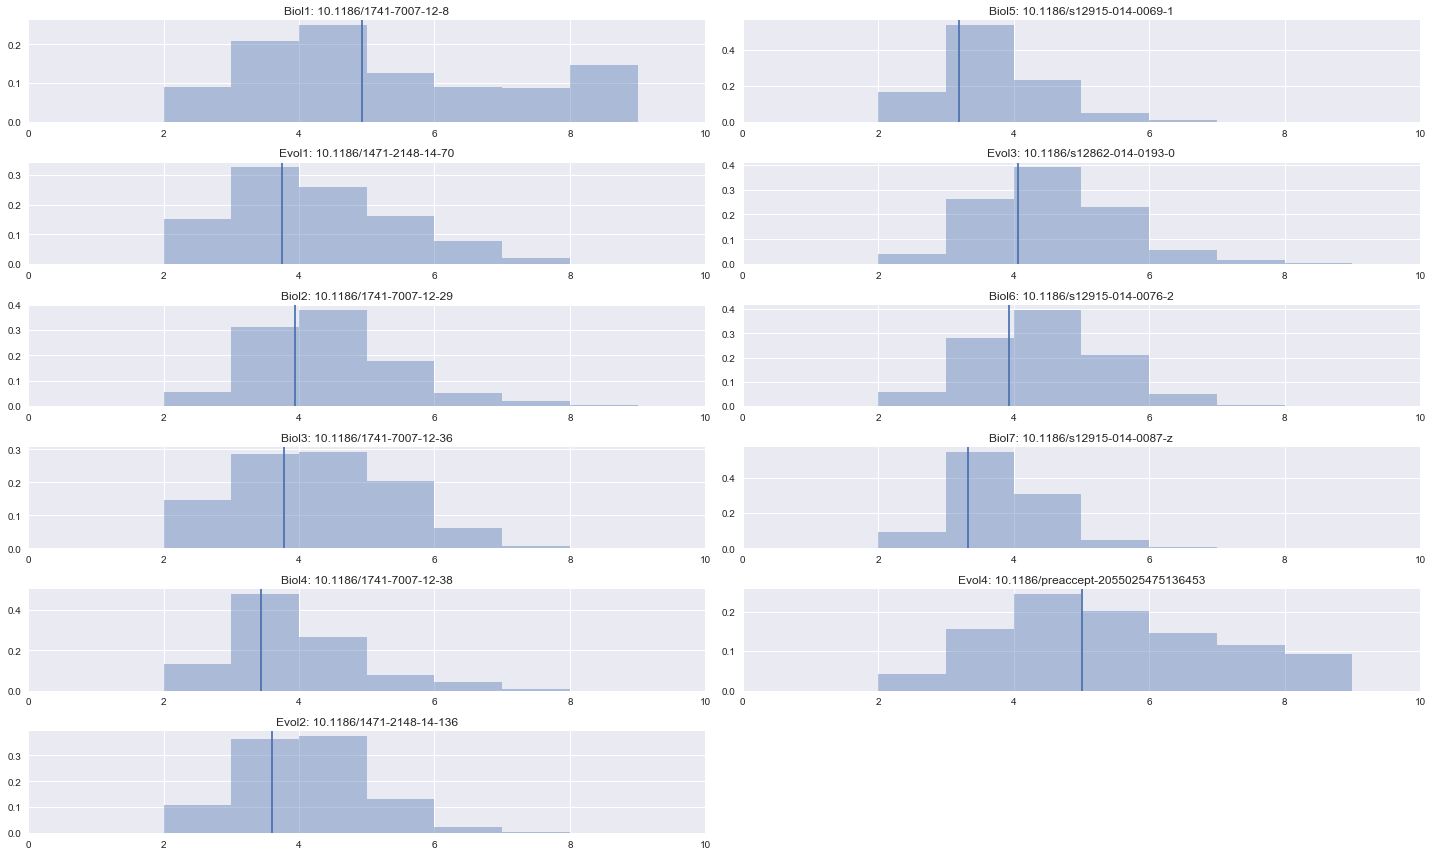

In [162]:
plt.rcParams['figure.figsize'] = (20.0, 12.0)
nrows = len(dois)/2 if len(dois)/2 % 2 == 0 else len(dois)//2+1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
plot_map = [(i,j) for j in range(ncols) for i in range(nrows)]

for i, doi in enumerate(dois): 
    path_lengths = pd.Series(map(len, shortest_paths[doi]))
    ax = axes[plot_map[i][0],plot_map[i][1]]
    ax.set_title("%s: %s" % (names.loc[doi]['name'], doi))
    sns.distplot(path_lengths, kde=False, norm_hist=True, bins=range(0,10), ax=ax)
    ax.set_xlim([0,10])
    ax.axvline(x=path_lengths.mean())

if len(dois) % 2 == 1:
    fig.delaxes(axes[-1,-1])

plt.tight_layout()
plt.savefig('data/%s/shortest_exp_paths_dist.png' % dataset)


In [ ]:
def grouped_first(grouped):
    if len(grouped) > 0:
        return grouped.iloc[0]
    return np.nan

def group_concat(grouped):
    try: 
        return "%s" % '||'.join(grouped)
    except TypeError:
        return ''

plt.rcParams['figure.figsize'] = (20.0, 12.0)

isolate_threshold = 4
nrows = len(dois)/2 if len(dois)/2 % 2 == 0 else len(dois)/2+1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
plot_map = [(i,j) for j in range(ncols) for i in range(nrows)]

for i, doi in enumerate(dois): 
    G = subgraphs[doi]
    infomap = infomaps[doi]
    
    df = pd.DataFrame(infomap.membership, columns=['membership'])
    df['user_id_str'] = df.index.map(lambda x: G.vs[x]['name'])
    
    tweets = tweetdetails[tweetdetails.doi == doi]
    tweets['event_number'] = tweets.index.map(lambda x: tweets.index.get_loc(x))
    tweets['user_id_str'] = tweets.user_id.astype(str)
    del tweets['user_id']
    tweets = tweets.merge(df, left_on='user_id_str', right_on='user_id_str')
    tweets['num_tweets'] = 1
    
    filename = 'data/%s/%s-tweets.csv' % (dataset, doi.replace('/','_'))
    df = tweets.groupby('user_id_str').agg({'doi': grouped_first, 
                                       'created_at': grouped_first, 
                                        'screen_name': grouped_first, 
                                        'old_screen_name': grouped_first,
                                        'user_utc_offset': grouped_first,
                                        'user_followers_count': grouped_first,
                                        'user_friends_count': grouped_first,
                                        'user_description': grouped_first,
                                        'is_retweet': grouped_first,
                                        'retweet_of_status_id_str': grouped_first,
                                        'retweet_of_screen_name': grouped_first,
                                        'is_reply': grouped_first,
                                        'in_reply_to_status_id_str': grouped_first,
                                        'in_reply_to_screen_name': grouped_first,
                                        'text': group_concat, 
                                        'num_tweets': lambda x: x.sum(),
                                        'event_number': grouped_first,
                                        'membership': grouped_first
                                       }).sort('created_at').reset_index().rename(columns={'user_id_str': 'ID', 'screen_name': 'Label'}).to_csv(filename, encoding='utf8', quotechar='"', index=False)
    
    for c, s in enumerate([g.vcount() for g in infomap.subgraphs()]):
        if s < 4:
            max_community_meets_threshold = c 
            break
            
    tweets['membership_i'] = tweets.membership.map(lambda x: x if x < max_community_meets_threshold else max_community_meets_threshold)
    
    activated_communities = set()
    num_activated_communities = []
    for e, c in tweets.membership_i.iteritems():
        activated_communities.add(c)
        num_activated_communities.append(len(activated_communities))
    tweets['community_activations'] = num_activated_communities

    if ncols == 1:
        ax=axes[i]
    else:
        ax=axes[plot_map[i][0],plot_map[i][1]]    
    tweets.community_activations.plot(style="or", ylim=[0, tweets.community_activations.max()+5], ms=5, alpha=0, ax=ax)
    for x, y in zip(tweets.index, tweets.community_activations):
        ax.text(x, y, tweets.ix[x]['membership_i'], color="blue", fontsize=12)
    ax.set_title(doi)
    plt.margins(0.1)


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


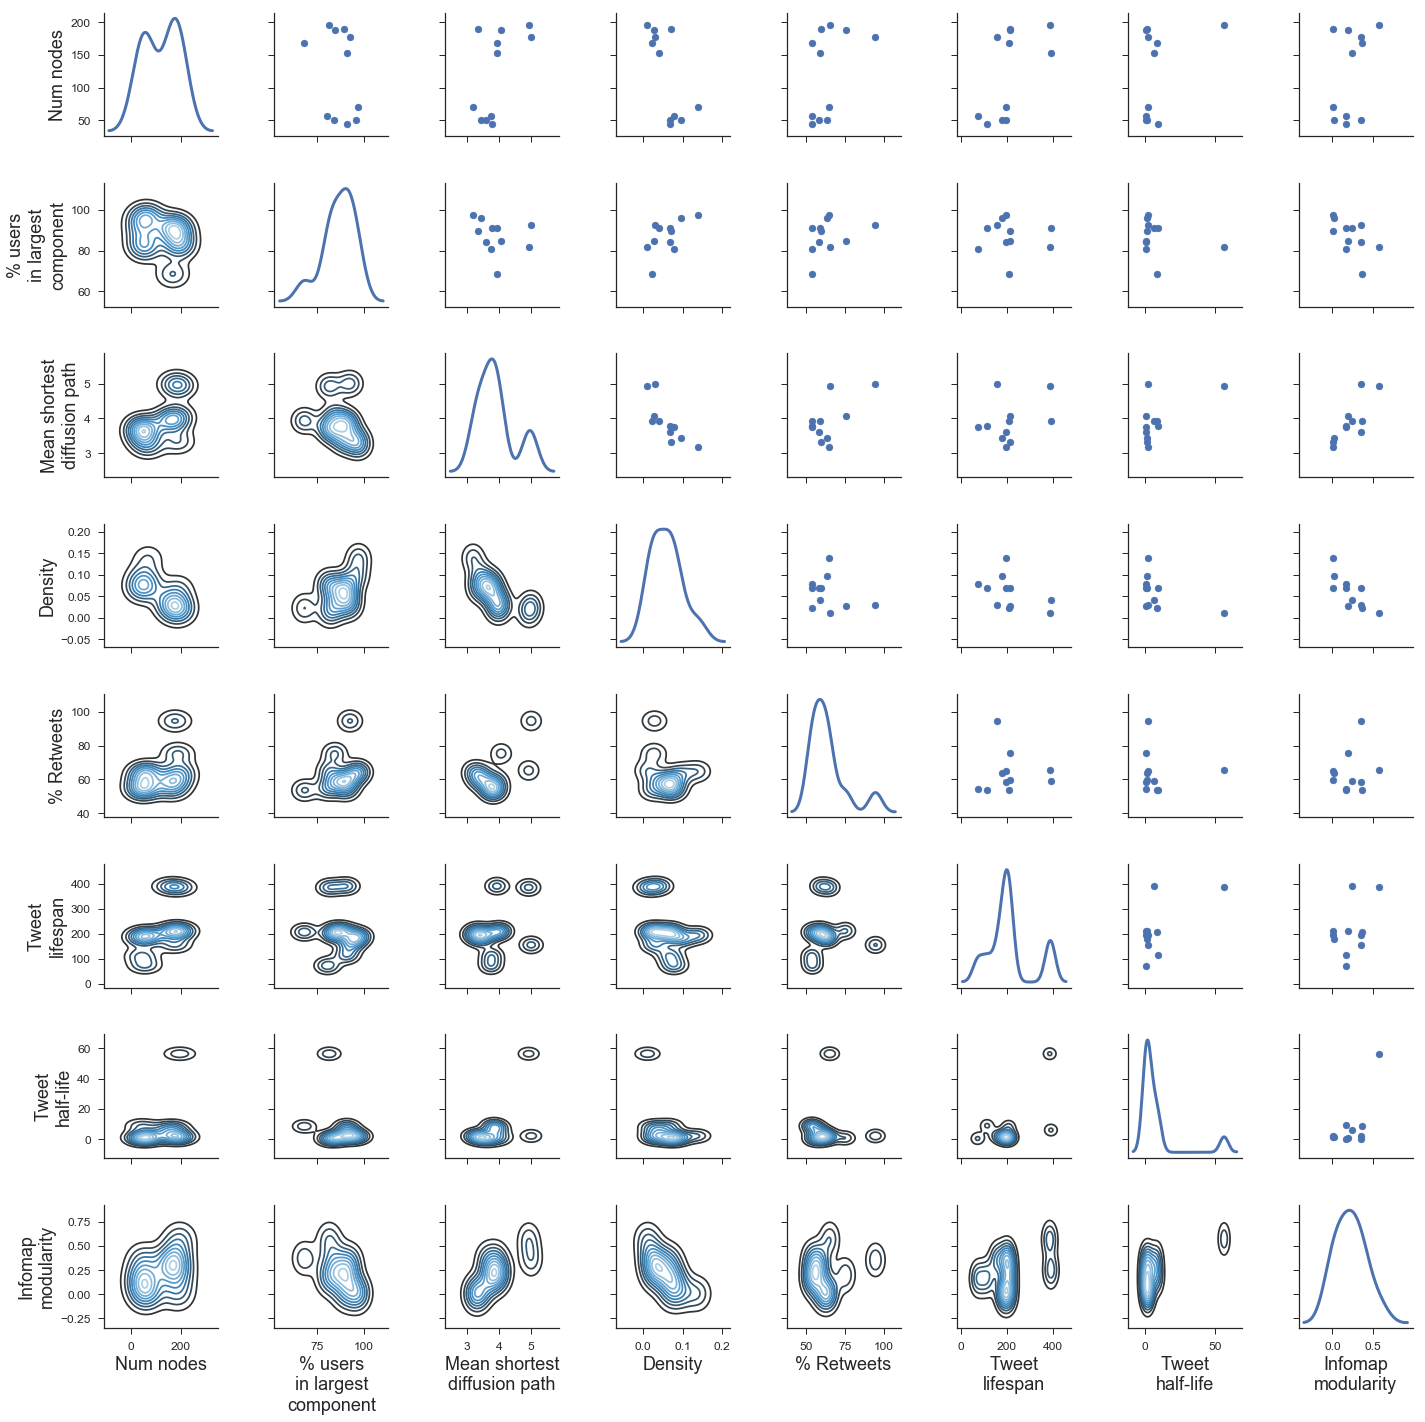

In [62]:
sns.set(style="white")
sns.set(style="ticks", color_codes=True)
plt.rcParams["axes.labelsize"] = 15

labels = ['Num nodes', '% users\nin largest\ncomponent', 'Mean shortest\ndiffusion path', 'Density', '% Retweets', 'Tweet\nlifespan', 'Tweet\nhalf-life', 'Infomap\nmodularity']
vars_to_plot = ['num_nodes', 'biggest_wcc_num_nodes_p', 'shortest_diffusion_path_length_mean', 'density', 'retweets_p', 'tweet_lifespan', 'tweet_halflife', 'biggest_wcc_infomap_modularity']

# vars_to_plot = ['num_nodes', 'biggest_wcc_num_nodes_p', 'shortest_diffusion_path_length_mean']

g = sns.PairGrid(all_stats, diag_sharey=False, vars=vars_to_plot)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

def sig_marker(p_value):
    if p_value < .01:
        sig = '***'
    elif p_value < .05:
        sig = '**'
    elif p_value < .1:
        sig = '*'
    else: 
        sig = ''     
    
    return sig

def corrfunc(x, y, **kws):
#     _, _, r_value, p_value, _ = stats.linregress(x, y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax = plt.gca()
    ax.plot(x, intercept + slope*x, 'r')
   
    ax.annotate("R-sq = {:.2f}".format(r_value**2) + sig_marker(p_value),
                xy=(.68, .1), xycoords=ax.transAxes)
    rho, p_value = stats.spearmanr(x, y)
    ax.annotate("rho = {:.2f}".format(rho**2) + sig_marker(p_value),
            xy=(.68, .2), xycoords=ax.transAxes)


# g.map_upper(corrfunc)

for i in range(len(vars_to_plot)):
    ax = g.axes[i][0]
    ax.set_ylabel(labels[i], fontsize=18)
    ax.tick_params(axis='y', labelsize=12)
    
    ax = g.axes[len(vars_to_plot)-1][i]
    ax.set_xlabel(labels[i], fontsize=18)
    ax.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.savefig('data/%s/scatterplot_kde.png' % dataset)

In [ ]:
x = df[df['tweet_halflife']<50]['tweet_halflife']
y = df[df['tweet_halflife']<50]['shortest_diffusion_path_length_mean']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(r_value**2, p_value)
print()
rho, p_value = stats.spearmanr(x, y)
print(rho, p_value)

In [ ]:
x = df['tweet_halflife']
y = df['shortest_diffusion_path_length_mean']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(r_value**2, p_value)
print()
rho, p_value = stats.spearmanr(x, y)
print(rho, p_value)

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
names.join(df)

In [ ]:
stats_summary = df.describe().transpose()
stats_summary[['mean', 'std', 'min', 'max', '50%']].style.format("{:.2f}")

In [ ]:
names.join(graph_stats).sort_values('shortest_diffusion_path_length_mean')

In [ ]:
# Weakly connected components
network_stats = {}
for doi in dois: 

    G = short_subgraphs[doi]
    print(doi)
    l = sorted([g.vcount() for g in G.components(mode=ig.WEAK).subgraphs()], reverse=True)
    print(l)
    print("%s, %.2f%%" % (l[0], l[0]*100.0/sum(l)))
    
    print
# ig.plot(G.community_infomap(), vertex_label=[v['event_number'] for v in G.vs])

In [ ]:
for doi in dois: 
    G = subgraphs[doi]
    G.community_infomap().modularity

    wccs = sorted(G.components(mode=ig.WEAK).subgraphs(), key=lambda g: g.vcount(), reverse=True)
    print(wccs[0].community_infomap().modularity)


In [ ]:
sns.set(style="white")
sns.set(style="ticks", color_codes=True)

df = all_stats[['num_nodes', 'biggest_wcc_num_nodes_p', 'shortest_paths_mean', 'density', 'retweets_p', 'tweet_lifespan', 'tweet_halflife', 'infomap_modularity']]

g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

from scipy import stats
def corrfunc(x, y, **kws):
#     _, _, r_value, p_value, _ = stats.linregress(x, y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax = plt.gca()
    ax.plot(x, intercept + slope*x, 'r')
    ax.annotate("R-sq = {:.2f}".format(r_value**2),
                xy=(.68, .1), xycoords=ax.transAxes)

g.map_upper(corrfunc)

plt.savefig('data/%s/scatterplot_kde.png' % dataset)

In [ ]:
doi = list(dois)[7]

G = short_subgraphs[doi]
ig.plot(G.community_infomap())

In [ ]:
doi = dois[5]
G = short_subgraphs[doi]
print doi
print len([g.vcount() for g in G.components(mode=ig.WEAK).subgraphs()])

In [ ]:
im = G.community_infomap()
[g.vcount() for g in im.subgraphs()]

In [ ]:
ig.plot(im.subgraphs()[2])

In [ ]:
ig.plot(infomap, vertex_label=[v['event_number'] for v in G.vs])

In [ ]:
G = graphs[doi]
tweets = tweetdetails[tweetdetails.doi == doi]
tweets['event_number'] = tweets.index.map(lambda x: tweets.index.get_loc(x))
tweets['user_id_str'] = tweets.user_id_str.astype(str)

tweeters = tweetdetails[tweetdetails.doi == doi].user_id_str.unique().astype(str)
tweeters = {v['name']: v.index for v in G.vs if v['name'] in tweeters}

subG = G.subgraph(tweeters.keys())
tweeters = {v['name']: v.index for v in subG.vs}
tweeters

In [ ]:
doi = dois[0]
G = subgraphs[doi]
tweeters = tweetdetails[tweetdetails.doi == doi].user_id_str.unique().astype(str)
tweeters = {v.index: v['name'] for v in G.vs if v['name'] in tweeters}
# tweeters = {v['name']: v.index for v in G.vs if v['name'] in tweeters}


In [ ]:
activated_communities = set()
num_activated_communities = []
for e, c in tweets.membership_i.iteritems():
    activated_communities.add(c)
    num_activated_communities.append(len(activated_communities))
tweets['community_activations'] = num_activated_communities

pylab.rcParams['figure.figsize'] = (12.0, 8.0)
tweets.community_activations.plot(style="or", ylim=[0, tweets.community_activations.max()+.5], ms=5, alpha=0)
for x, y in zip(tweets.index, tweets.community_activations):
#     print x,y
    plt.text(x, y, tweets.ix[x]['membership_i'], color="red", fontsize=12)
# plt.margins(0.1)

In [ ]:
tweets.membership.plot.hist(bins=range(tweets.membership.max()))

In [ ]:
for doi in dois:
    print doi, [g.vcount() for g in wccs[doi].subgraphs()]

In [ ]:
doi = dois[1]
for doi in dois: 
    G = graphs[doi]
    tweeters = tweetdetails[tweetdetails.doi == doi].user_id_str.unique().astype(str)
    tweeters = {v['name']: v.index for v in G.vs if v['name'] in tweeters}
    
    wcc = G.subgraph(tweeters.keys()).components(mode=ig.WEAK)
    print [g.vcount() for g in wcc.subgraphs()]

In [ ]:
# infomap = infomaps.values()[0]
for doi, infomap in infomaps.items(): 
    print(doi, infomap.modularity, [g.vcount() for g in infomap.subgraphs()])

In [ ]:
['Scientist', 'Publisher', 'Public', 'Scientist (non-research)',
       'Aggregator', 'Blogger', 'Institution']

def make_label(s): 
    if s.find('(') > 0:
        return 'Sn'
    elif s == 'Publisher':
        return 'Ps'
    else:
        return s[0]

In [ ]:
doi = dois[0]
G = subgraphs[doi]
infomap = infomaps[doi]

In [ ]:
user_classifications = pd.read_csv('data/user_classifications.tsv', sep='\t', dtype={'user_id': str})
user_classifications = user_classifications.drop_duplicates()

df = pd.DataFrame(infomap.membership, columns=['membership'], )
df['user_id'] = df.index.map(lambda x: G.vs[x]['name'])

df = df.merge(user_classifications, left_on="user_id", right_on="user_id", how='inner')
print len(df)

In [ ]:
print G.shortest_paths(35, 34)
print G.shortest_paths(34, 35)

In [ ]:
ig.plot(infomap, vertex_label=[df.ix[v.index]['user_id'] for v in G.vs])

In [ ]:
tweets = pd.read_csv('data/%s/1741-7007-12-36-tweets.csv' % dataset)
edgelist = pd.read_csv('data/%s/1741-7007-12-36-edgelist.tsv' % dataset, sep='\t', header=None, names=['in', 'out'])
edgelist[(edgelist['in'].isin(tweets.user_id_str.unique())) | (edgelist['out'].isin(tweets.user_id_str.unique()))].to_csv('data/tmp.tsv', index=False, sep='\t', header=False)
G = ig.Graph.Read_Ncol('data/tmp.tsv', names=True, directed=True)


In [ ]:
s.

In [ ]:
set([v['name'] for v in G.vs]).difference(tweets.user_id_str)

In [ ]:
ig.plot(G.community_infomap())

In [ ]:
tweets.head()

In [ ]:
infomap.modularity

In [ ]:
df.groupby('membership').size().head()

In [ ]:
df.groupby(['membership', 'usertype']).size().multiply(100.0).divide(df.groupby('membership').size())

In [ ]:
len(df) #.groupby('usertype').size()

In [ ]:
gb['p'] = gb

In [ ]:
gb

In [ ]:
# {v: k for k, v in tweeters.iteritems() if v in [11607, 4916, 6622, 4868]}
for v in [11607, 4916, 6622, 4868]:
    for k, v2 in tweeters.iteritems():
        if v == v2:
            print k, v

In [ ]:
edgelist = pd.read_csv('data/evolBioAllFollowers.csv', dtype={'in': str, 'out': str, 'doi': str}).drop_duplicates()
e = pd.read_csv('data/evolBioAllFriends.csv', dtype={'in': str, 'out': str, 'doi': str}).drop_duplicates()
edgelist = edgelist.append(e)
del e

edgelist = edgelist[edgelist.doi == doi]

In [ ]:
len(edgelist.drop_duplicates())

In [ ]:
for v in G.vs:
    if v.degree() > 40000:
        print v['name'], v.degree(), v
        biomed = v
        break

In [ ]:
df.degree.plot(style='o', logx=True, logy=True, alpha=.5)

In [ ]:
counts, bins = np.histogram(df.degree, density=True)

bar(bins[:-1],counts/float(sum(counts)),width=bins[1]-bins[0])
ylabel("fraction of nodes")

bar(bins[:-1],counts/float(sum(counts)),width=bins[1]-bins[0],log=True)
#hist(ks,bins=arange(min(ks),max(ks)),normed=True,log=True)
xlabel("degree")
ylabel("fraction of nodes")

In [ ]:
maxdegfound=int(ceil(max(bins)))
counts,bins=np.histogram(df.degree,bins=maxdegfound)


countsnozero=counts*1.
countsnozero[counts==0]=-Inf

figure()
scatter(bins[:-1],countsnozero/float(sum(counts)),s=60)
yscale('log')
xscale('log')
ylim(0.00008,1.1)
xlim(0.8,1100)
xlabel('degree')
ylabel("fraction of nodes")
subplots_adjust(bottom=0.15)

In [ ]:
df.degree.value_counts().head()

In [ ]:
df.degree.value_counts(normalize=False)

In [ ]:
plt.loglog(df.degree.value_counts(normalize=True).sort_index(), marker='o')

In [ ]:
try:
    del e
except: 
    pass

total_edges = 0

for doi in dois:
    filename = 'data/%s/%s-edgelist.csv' % (dataset, doi.replace('/','_'))
    df = pd.read_csv(filename)
    total_edges += len(df)
    try: 
        e = e.append(df)
    except:
        e = df

In [ ]:

e.to_csv('data/%s/all_dois-edgelist.csv' % dataset, index=False)

In [ ]:
e = e.drop_duplicates()
e.to_csv(filename, index=False)

In [ ]:
filename = 'tmp.edgelist'
e.to_csv('tmp.edgelist', index=False, sep="\t", header=None) # keep as TSV for iGraph
print('wrote')
allG = ig.Graph.Read_Ncol('tmp.edgelist', names=True, directed=True)



In [ ]:
tweetdetails.columns

In [ ]:
tweets = tweetdetails
tweets['event_number'] = tweets.index.map(lambda x: tweets.index.get_loc(x))

tweeters = tweetdetails.user_id.unique().astype(str)

In [ ]:
G = allG.subgraph(tweeters)


In [ ]:
filename = 'data/%s/all_dois-subgraph-edgelist.csv' % dataset
G.write_ncol(filename)
# df = pd.read_csv(filename, sep=" ", header=None)
# df.columns = ['Source', 'Target']
# df.to_csv(filename, index=False)
# del df

In [ ]:
infomap = G.community_infomap()

In [ ]:
from collections import Counter
cnt = Counter(infomap.membership)

In [ ]:
infomap.modularity

In [ ]:
user_id_screen_name_map = {str(k):v for (k,v) in zip(list(users_df.index), list(users_df.screen_name))}

In [ ]:
memberships = {k:v for (k,v) in zip([user_id_screen_name_map[v['name']] for v in G.vs], infomap.membership)}

In [ ]:
s = pd.Series(infomap.membership, index=[user_id_screen_name_map[v['name']] for v in G.vs])
s.name='community_number'
s.to_excel('data/comm/whole_network_infomap_community_memberships.xlsx')

In [ ]:
cnt_reverse = {v:k for (k,v) in cnt.items()}

In [ ]:
sum([cnt_reverse[x+1] for x in range(10)])

In [ ]:
cnt_reverse

In [ ]:
sum([1520, 300, 273, 261, 211, 199, 193, 134, 134, 120])

In [ ]:
sorted(cnt.values(), reverse=True)[0:30]

In [ ]:
sns.distplot(list(cnt.values()))

In [ ]:
print("%s\t%s\t%s" % (doi, G.vcount(), G.ecount()))

graph_stats = {}
graph_stats['density'] = G.density()
graph_stats['num_nodes'] = G.vcount()
graph_stats['num_edges'] = G.ecount()
graph_stats['diameter'] = G.diameter()

graph_stats['in_degree_mean'] = np.mean(G.indegree())
graph_stats['out_degree_mean'] = np.mean(G.outdegree())
graph_stats['degree_mean'] = np.mean(G.degree())

wccs = sorted(G.components(mode=ig.WEAK).subgraphs(), key=lambda g: g.vcount(), reverse=True)
graph_stats['biggest_wcc_num_nodes'] = wccs[0].vcount()
graph_stats['biggest_wcc_num_nodes_p'] = wccs[0].vcount()*100.0/G.vcount()
graph_stats['biggest_wcc_density'] = wccs[0].density()
graph_stats['biggest_wcc_infomap_modularity'] = wccs[0].community_infomap().modularity


In [ ]:
graph_stats

In [ ]:
subG = 

In [ ]:
tweetdetails = pd.read_csv('data/BMCevolBioTweetDetails.txt', encoding='utf8', sep="\t", index_col='tweet_id')
tweetdetails.sort_index(inplace=True)

# dois = dois + list(tweetdetails.doi.unique())
dois = list(tweetdetails.doi.unique())
print dois

In [ ]:
tweetdetails = pd.read_csv('data/BMCBioTweetDetails.txt', encoding='utf8', sep="\t", index_col='tweet_id')
tweetdetails.sort_index(inplace=True)

dois = list(tweetdetails.doi.unique())
print dois

In [ ]:
tweetdetails = pd.read_csv('data/BMCBioTweetDetails.csv', encoding='utf8', index_col='tweet_id')
tweetdetails.sort_index(inplace=True)

dois = list(tweetdetails.doi.unique())

tweetdetails['created_at'] = pd.to_datetime(tweetdetails.created_at)
tweetdetails['user_id_str'] = tweetdetails.user_id_str.astype(int)

con = sqlite3.connect("data/BMCbioSample.db")
friends = pd.read_sql_query("SELECT * FROM friends", con, index_col="user_id")
friends.index = friends.index.astype(int)
followers = pd.read_sql_query("SELECT * FROM followers", con, index_col="user_id")
followers.index = followers.index.astype(int)

df = tweetdetails[['doi', 'user_id_str']].drop_duplicates().set_index('user_id_str').join(friends)[['friend_id', 'doi']]
# df.index.rename('user_id', inplace=True)

edgelist = df.reset_index()
edgelist.columns = ['in', 'out', 'doi']
edgelist = edgelist.drop_duplicates()

tweetdetails_BMC = tweetdetails
edgelist_BMC = edgelist

graphs = {}
for doi in dois: 
    e = edgelist[edgelist.doi == doi]
    del e['doi']
    
    filename = 'data/%s/%s-edgelist.csv' % (dataset, doi.replace('/','_'))
    e.columns = ['Source', 'Target']
    e.to_csv(filename, index=False, sep="\t", header=None) # keep as TSV for iGraph
    graphs[doi] = ig.Graph.Read_Ncol(filename, names=True, directed=True)
    e.to_csv(filename, index=False) 

tweetdetails = pd.read_csv('data/BMCevolBioTweetDetails.csv', encoding='utf8', index_col='tweet_id')
tweetdetails.sort_index(inplace=True)

# dois = dois + list(tweetdetails.doi.unique())
dois = list(tweetdetails.doi.unique())

tweetdetails['created_at'] = pd.to_datetime(tweetdetails.created_at)
tweetdetails['user_id_str'] = tweetdetails.user_id_str.astype(int)

edgelist = pd.read_csv('data/evolBioAllFollowers.csv', dtype={'in': str, 'out': str, 'doi': str}).drop_duplicates()
e = pd.read_csv('data/evolBioAllFriends.csv', dtype={'in': str, 'out': str, 'doi': str}).drop_duplicates()
edgelist = edgelist.append(e).drop_duplicates()
del e

tweetdetails = tweetdetails.append(tweetdetails_BMC)
del tweetdetails_BMC
edgelist = edgelist.append(edgelist_BMC)
del edgelist_BMC

for doi in dois:  
    e = edgelist[edgelist.doi == doi]
    del e['doi']

    filename = 'data/%s/%s-edgelist.csv' % (dataset, doi.replace('/','_'))
    e.columns = ['Source', 'Target']
    e.to_csv(filename, index=False, sep="\t", header=None)
    graphs[doi] = ig.Graph.Read_Ncol(filename, names=True, directed=True)
    e.to_csv(filename, index=False)
#     os.remove('data/edgelist.tsv')

dois = list(tweetdetails.doi.unique())